In [1]:
%run Function_set_gurobi.ipynb
import networkx as nx
import numpy as np
from collections import defaultdict
import random
from numpy import random
import matplotlib.pyplot as plt

In [2]:
from collections import defaultdict

import numpy as np
import gurobipy as gp
from gurobipy import GRB
from gurobipy import*
from gurobipy import quicksum

In [32]:
network,pos = Make_Question(3,4,Density = 0.7, option = "1-norm", distance = 2)

print(network)

[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 1. 0. 1.]
 [1. 0. 0. 0. 0. 1. 0. 1. 0.]]


{(1, 0): '0', (2, 0): '1', (3, 0): '2', (4, 0): '3', (5, 0): '4', (6, 0): '5', (7, 0): '6', (8, 0): '7', (1, 2): '8', (1, 3): '9', (3, 4): '12', (4, 5): '14', (4, 7): '15', (5, 8): '17', (6, 7): '18', (7, 8): '21', (2, 1): '10', (3, 1): '11', (4, 3): '13', (5, 4): '16', (7, 4): '19', (7, 6): '20', (8, 5): '22', (8, 7): '23'}


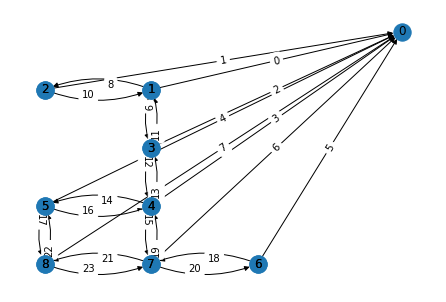

In [33]:
G, compelete_label, graph = complete_Graph(network,pos)
print(compelete_label)

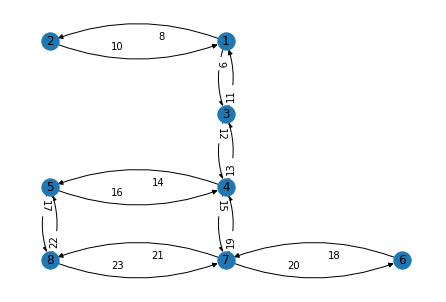

In [34]:
G_prime, sub_edge_label, sub_graph = sub_Graph (network,pos)

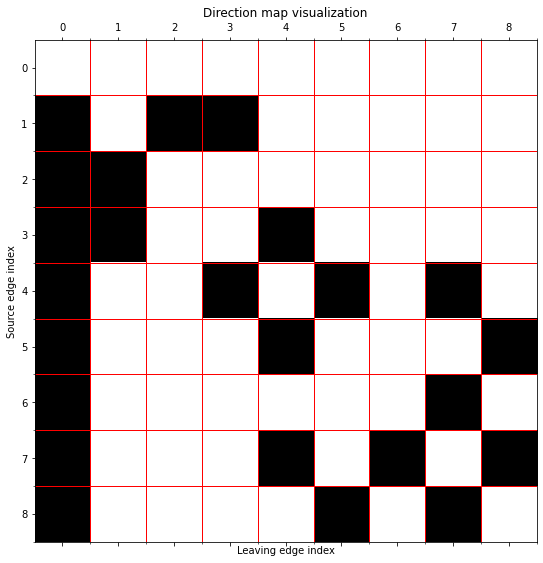

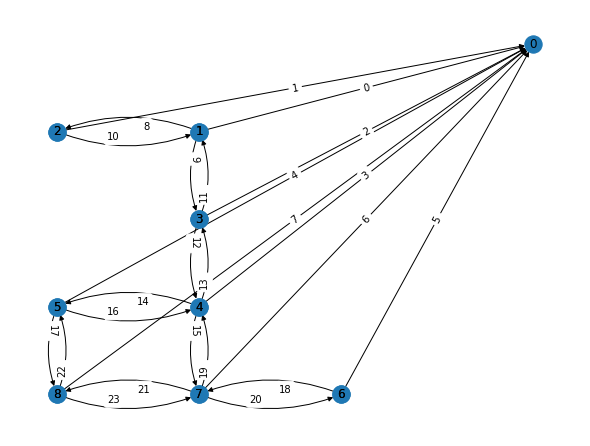

In [35]:
#matfig = plt.figure(figsize=(Final_map.shape[0],Final_map.shape[1]))
matfig = plt.figure(figsize=(9,9))
plt.matshow(network,cmap=plt.cm.binary,fignum=matfig.number)
ax = plt.gca()
#plt.matshow(Final_map,cmap=plt.cm.binary)
plt.xlabel('Leaving edge index')
plt.ylabel('Source edge index')
plt.title ("Direction map visualization")

# Major ticks
ax.set_xticks(np.arange(0, network.shape[0], step=1))
ax.set_yticks(np.arange(0, network.shape[0], step=1))

# Labels for major ticks
ax.set_xticklabels(np.arange(0, network.shape[0], step=1))
ax.set_yticklabels(np.arange(0, network.shape[0], step=1))

# Minor ticks
ax.set_xticks(np.arange(0.5, network.shape[0]+0.5, step=1), minor=True)
ax.set_yticks(np.arange(0.5, network.shape[0]+0.5, step=1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='r', linestyle='-', linewidth=1)

plt.show()


plt.figure(2,figsize=(8,6)) 
_, _, _ = complete_Graph(network,pos)

In [36]:
%run Function_set_gurobi.ipynb
# How many panel ---> Max electricity level wire could reach 
Q = len(pos)-1

N_tree = capacity_subtree_limit_generator(pos,Q)

1 3


In [37]:
%run Function_set_gurobi.ipynb

print(Q)

# How many edges
edge_number = len(compelete_label)


# basic_cost shape => (1,number_of_edge)
# such as : basic_cost = np.vstack(np.ones(number_of_edge))
# test case : #basic_cost = np.arange(edge_number)

basic_cost = np.ones(edge_number) * 2


# flow cost (p)
flow_cost = np.ones(edge_number) 
p = 1


# make dictionary
edge_dictionary, Total = make_dictionary(edge_number, Q, N_tree)

# initialize a QUBO matrix needed
QUBO_matrix_initial = np.zeros((Total, Total))


print('N_tree  = ', N_tree )
#print('edge_dictionary  = ', edge_dictionary )

8
N_tree  =  [2 3]


In [38]:
c_e = (np.tile(np.vstack(basic_cost),(1,Q+1)))
        
level_coeff = (np.tile(np.arange(1,Q + 1),(edge_number,1))).flatten()

In [39]:
def constraint_1(Final_map, Q, edge_dictionary, compelete_label, vertex):
    
    index = np.hstack(np.asarray(np.where(Final_map[vertex,:])))             
            
    index_matched = []
    
    for vertex_selected in index:
            
        #print(int(compelete_label[(vertex, vertex_selected)]))
        
            index_matched.append( int(compelete_label[(vertex, vertex_selected)]) )
    
    return index_matched


In [40]:
def constraint_2(Final_map, Q, edge_dictionary, compelete_label, vertex):
    
    index_out = np.hstack(np.asarray(np.where(Final_map[vertex,:])))             
            
    index_out_matched = []
    
    for vertex_selected in index_out:
            
        index_out_matched.append( int(compelete_label[(vertex, vertex_selected)])  )
    
    index_in = np.hstack(np.asarray(np.where(Final_map[:,vertex])))
    
    index_in_matched = []
    
    for vertex_selected in index_in:
        index_in_matched.append( int(compelete_label[(vertex_selected, vertex )])  )

    
    return index_out_matched, index_in_matched

In [41]:
try:

    # Create a new model
    m = gp.Model("Solar_panel_new_model")

    # Create variables
    x = m.addVars(edge_number, Q, vtype=GRB.BINARY, name="x")
    s = m.addMVar(len(N_tree), vtype=GRB.BINARY, name="s")
    
    print(x[0,1])
    # Set objective
    m.setObjective( quicksum(s[m] * 
                             quicksum(quicksum((p*j+1) * c_e[i,j]  * x[i,j] for i in range(edge_number)) for j in range(Q)) 
                             for m in range(len(N_tree))), GRB.MAXIMIZE)

    # Add constraint 1:
    for vertex in range(1, Q + 1):
    
        index = constraint_1(network, Q, edge_dictionary, compelete_label, vertex)

        # 
        m.addConstr(quicksum( quicksum(x[i,j] for j in range(Q)) for i in index) == 1, name=f'constraint_1_vertex_{vertex}')

    # Add constraint 2:  
    for vertex in range(1, Q + 1):
    
        index_out, index_in = constraint_2(network, Q, edge_dictionary, compelete_label, vertex)
    
        #print(index_out, index_in, level_coeff[index_in])
    
        m.addConstr( quicksum(quicksum( (j+1) * x[i,j] for j in range(Q)) for i in index_out) - quicksum( quicksum( (n+1) * x[m,n] for n in range(Q)) for m in index_in)  == 1, name=f'constraint_2_vertex_{vertex}')

    # Add constraint 4:
    m.addConstr(quicksum(quicksum( x[m,n] for n in range(Q)) for m in range(Q)) - quicksum( coeff * s[i] for  i, coeff in enumerate(N_tree) ) == 0, name=f'constraint_4')
    
    # Add constraint 5:
    m.addConstr(s.sum() == 1, name=f'constraint_5')

    # Optimize model
    m.optimize()
    print (m.display())

    #$for v in m.getVars():
        #print('%s %g' % (v.varName, v.x))

    x_list = [str.replace(str.replace(v.varName,"]",""),"x[","") for v in m.getVars() if v.x == 1 and v.varName[0] =='x']
    s_choice = [str.replace(str.replace(v.varName,"]",""),"s[","") for v in m.getVars() if v.x == 1 and v.varName[0] =='s']
    
    print(x_list, "The subtree number is", N_tree[int(s_choice[0])] )
    
    #print('Obj: %g' % m.objVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

<gurobi.Var *Awaiting Model Update*>
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads
Optimize a model with 18 rows, 194 columns and 580 nonzeros
Model fingerprint: 0x2f10bf5c
Model has 384 quadratic objective terms
Variable types: 0 continuous, 194 integer (194 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1 rows and 46 columns
Presolve time: 0.00s
Presolved: 17 rows, 148 columns, 426 nonzeros
Variable types: 0 continuous, 148 integer (148 binary)
Found heuristic solution: objective 30.0000000

Root relaxation: objective 9.220408e+01, 32 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

  

+ 12.0 x[18,5] * s[1] + 14.0 x[18,6] * s[0] + 14.0 x[18,6] * s[1] + 16.0 x[18,7] * s[0]
+ 16.0 x[18,7] * s[1] + 2.0 x[19,0] * s[0] + 2.0 x[19,0] * s[1] + 4.0 x[19,1] * s[0]
+ 4.0 x[19,1] * s[1] + 6.0 x[19,2] * s[0] + 6.0 x[19,2] * s[1] + 8.0 x[19,3] * s[0]
+ 8.0 x[19,3] * s[1] + 10.0 x[19,4] * s[0] + 10.0 x[19,4] * s[1] + 12.0 x[19,5] * s[0]
+ 12.0 x[19,5] * s[1] + 14.0 x[19,6] * s[0] + 14.0 x[19,6] * s[1] + 16.0 x[19,7] * s[0]
+ 16.0 x[19,7] * s[1] + 2.0 x[20,0] * s[0] + 2.0 x[20,0] * s[1] + 4.0 x[20,1] * s[0]
+ 4.0 x[20,1] * s[1] + 6.0 x[20,2] * s[0] + 6.0 x[20,2] * s[1] + 8.0 x[20,3] * s[0]
+ 8.0 x[20,3] * s[1] + 10.0 x[20,4] * s[0] + 10.0 x[20,4] * s[1] + 12.0 x[20,5] * s[0]
+ 12.0 x[20,5] * s[1] + 14.0 x[20,6] * s[0] + 14.0 x[20,6] * s[1] + 16.0 x[20,7] * s[0]
+ 16.0 x[20,7] * s[1] + 2.0 x[21,0] * s[0] + 2.0 x[21,0] * s[1] + 4.0 x[21,1] * s[0]
+ 4.0 x[21,1] * s[1] + 6.0 x[21,2] * s[0] + 6.0 x[21,2] * s[1] + 8.0 x[21,3] * s[0]
+ 8.0 x[21,3] * s[1] + 10.0 x[21,4] * s[0] + 10.0 x[21,

constraint_2_vertex_8: <gurobi.LinExpr: x[7,0] + 2.0 x[7,1] + 3.0 x[7,2] + 4.0 x[7,3] +
5.0 x[7,4] + 6.0 x[7,5] + 7.0 x[7,6] + 8.0 x[7,7] + -1.0 x[17,0] + -2.0 x[17,1] + -3.0
x[17,2] + -4.0 x[17,3] + -5.0 x[17,4] + -6.0 x[17,5] + -7.0 x[17,6] + -8.0 x[17,7] +
-1.0 x[21,0] + -2.0 x[21,1] + -3.0 x[21,2] + -4.0 x[21,3] + -5.0 x[21,4] + -6.0 x[21,5]
+ -7.0 x[21,6] + -8.0 x[21,7] + x[22,0] + 2.0 x[22,1] + 3.0 x[22,2] + 4.0 x[22,3] + 5.0
x[22,4] + 6.0 x[22,5] + 7.0 x[22,6] + 8.0 x[22,7] + x[23,0] + 2.0 x[23,1] + 3.0 x[23,2]
 + 4.0 x[23,3] + 5.0 x[23,4] + 6.0 x[23,5] + 7.0 x[23,6] + 8.0 x[23,7]> = 1
constraint_4: <gurobi.LinExpr: x[0,0] + x[0,1] + x[0,2] + x[0,3] + x[0,4] + x[0,5] +
x[0,6] + x[0,7] + x[1,0] + x[1,1] + x[1,2] + x[1,3] + x[1,4] + x[1,5] + x[1,6] + x[1,7]
+ x[2,0] + x[2,1] + x[2,2] + x[2,3] + x[2,4] + x[2,5] + x[2,6] + x[2,7] + x[3,0] +
x[3,1] + x[3,2] + x[3,3] + x[3,4] + x[3,5] + x[3,6] + x[3,7] + x[4,0] + x[4,1] + x[4,2]
+ x[4,3] + x[4,4] + x[4,5] + x[4,6] + x[4,7] + x[5,0] + 

Gurobi runtime is 0.03302764892578125 seconds
widths [2, 1, 3, 4, 5, 1, 7, 6]


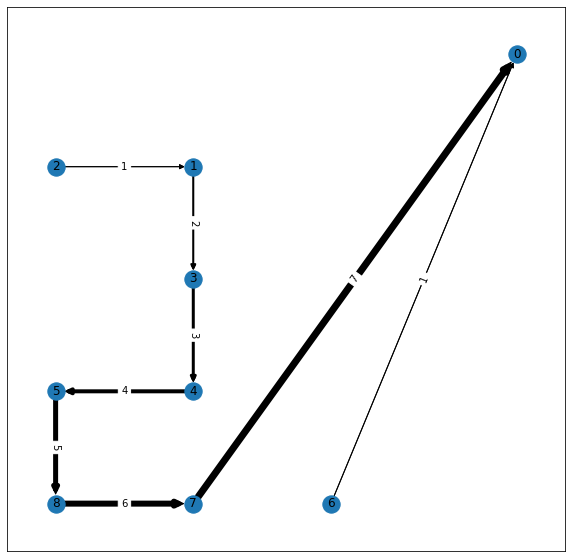

In [42]:
print("Gurobi runtime is", m.Runtime ,"seconds")
final_G = nx.DiGraph()
final_G = nx.from_numpy_array(np.zeros_like(network),create_using=nx.DiGraph(directed=True))

#print(str(final_index // Q))
#print(str(final_index % Q))

for item in x_list:
    #print(item)
    
    index, level = item.split(',')
    
    #print(index, int(level) + 1)
    
    final_G.add_weighted_edges_from([(*edge, int(level)+1)  for edge, label in compelete_label.items() if label == index ])
    


    
matfig = plt.figure(figsize=(10,10)) 
labels = nx.get_edge_attributes(final_G,'weight')
widths = list(nx.get_edge_attributes(final_G,'weight').values())
print("widths",widths)
nx.draw_networkx(final_G, pos)
nx.draw_networkx_edge_labels(final_G,pos,edge_labels = labels)
nx.draw_networkx_edges(final_G,pos,width = widths)